**Problem Statement**

**Prediction Salary** 

# Import

In [69]:
#data stuff
import pandas as pd

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

#NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
# from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import gensim

#other
from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

## Check the data

In [70]:

data = pd.read_csv('./data/san-francisco-payroll_2011-2019.csv',low_memory=False)
data.head(2)

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,Janet Lee Miller,Court Staff Attorney II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,Gary Mar,Electrical Transit System Mech,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT


In [71]:
data.isna().sum()

Employee Name                0
Job Title                    0
Base Pay                     0
Overtime Pay                 0
Other Pay                    0
Benefits                     0
Total Pay                    0
Total Pay & Benefits         0
Year                         0
Status                  151501
dtype: int64

## EDA

In [72]:
data[data["Employee Name"]=="A Bernard Fatooh"]

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
27362,A Bernard Fatooh,Sheriff's Property Keeper,29256.23,0.0,0.0,7334.78,29256.23,36591.01,2019,PT
66418,A Bernard Fatooh,Sheriff's Property Keeper,25232.9,0.0,0.0,6037.79,25232.90,31270.69,2018,PT
112016,A Bernard Fatooh,Sheriff's Property Keeper,29525.24,0.0,0.0,6713.17,29525.24,36238.41,2017,PT
153467,A Bernard Fatooh,Sheriff's Property Keeper,25896.17,0.00,0.00,11698.73,25896.17,37594.90,2016,NaN
172136,A Bernard Fatooh,Sheriff's Property Keeper,26896.89,0.0,0.0,6466.82,26896.89,33363.71,2015,PT
232019,A Bernard Fatooh,Sheriff's Property Keeper,24061.35,0.0,0.0,6091.68,24061.35,30153.03,2014,PT
303874,A Bernard Fatooh,Sheriff's Property Keeper,18472.35,0.0,27.84,5014.66,18500.19,23514.85,2012,NaN


In [73]:
data.Year.value_counts()

2019    44525
2018    42309
2017    41566
2016    40970
2015    39387
2014    38119
2013    37606
2012    36766
2011    36159
Name: Year, dtype: int64

In [74]:
data.groupby(by='Employee Name').count() > 5

,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
Employee Name,,,,,,,,,
A BERNARD FATOOH,False,False,False,False,False,False,False,False,False
A Bernard Fatooh,False,False,False,False,False,False,False,False,False
A Bernard Fatooh,True,True,True,True,True,True,True,True,False
A ELIZABETH MARCHASIN,False,False,False,False,False,False,False,False,False
A JAMIL NIAZI,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
Zuri Jones,True,True,True,True,True,True,True,True,False
Zuri S Chavarin Cerda,False,False,False,False,False,False,False,False,False
Zuzanna E Czerw,False,False,False,False,False,False,False,False,False


In [75]:
data['Employee Name']=data['Employee Name'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z0-9 ]', '', regex=True)
data['Job Title']=data['Job Title'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z ]', '', regex=True)
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,JANET LEE MILLER,COURT STAFF ATTORNEY II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
3,KRISTIAN C SMOCK,STATIONARY ENG SEWAGE PLANT,106816.03,0.0,0.0,38729.65,106816.03,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,94039.13,14947.99,1241.69,35330.26,110228.81,145559.07,2019,FT
...,...,...,...,...,...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,46106.73,890.49,4839.07,Not Provided,51836.29,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,48472.4,1972.35,1390.5,Not Provided,51835.25,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,46046.29,1853.97,3934.44,Not Provided,51834.70,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,47798.87,0.0,4032.55,Not Provided,51831.42,51831.42,2011,NaN


In [76]:
df=data[['Employee Name', 'Job Title', 'Total Pay & Benefits', 'Year', 'Status']]
df.columns=['Employee Name', 'Job Title', 'Salary', 'Year', 'Status']
df=df[df['Salary']!=0.0]
df

,Employee Name,Job Title,Salary,Year,Status
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,145545.42,2019,FT
3,KRISTIAN C SMOCK,STATIONARY ENG SEWAGE PLANT,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,145559.07,2019,FT
5,DANIEL AGUADA,AUTOMOTIVE MECHANIC,145568.96,2019,FT
...,...,...,...,...,...
357402,HOWARD CHUCK,CUSTODIAN,51836.29,2011,NaN
357403,BING KEUNG MAK,CUSTODIAN,51835.25,2011,NaN
357404,QIN MING ZHU,CUSTODIAN,51834.70,2011,NaN
357405,JOSE ALONZO,CUSTODIAN,51831.42,2011,NaN


In [77]:
start_salary=df.sort_values(by='Year').groupby(by='Employee Name').agg({'Salary':'first', 'Year':'first'}).reset_index()
start_salary.columns=['Employee Name', 'Start Salary', 'Start Year']
start_salary

,Employee Name,Start Salary,Start Year
0,A BERNARD FATOOH,20039.91,2011
1,A ELIZABETH MARCHASIN,26282.86,2011
2,A JAMES ROBERTSON II,19473.92,2011
3,A JAMIL NIAZI,87496.21,2011
4,A K FINIZIO,26113.37,2014
...,...,...,...
94077,ZURHI N CHICUATA,3205.74,2017
94078,ZURI JONES,70888.04,2011
94079,ZURI S CHAVARIN CERDA,5941.65,2017
94080,ZUZANNA E CZERW,3594.04,2017


In [78]:
merge_df=df.merge(start_salary, on ='Employee Name', how='left').sort_values(['Employee Name','Year']).reset_index(drop=True)
merge_df.columns=['Employee Name', 'Job Title', 'End Salary', 'End Year', 'Status','Start Salary', 'Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,20039.91,2011,NaN,20039.91,2011
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,23514.85,2012,NaN,20039.91,2011
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,29379.24,2013,NaN,20039.91,2011
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,30153.03,2014,PT,20039.91,2011
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,33363.71,2015,PT,20039.91,2011
...,...,...,...,...,...,...,...
357343,ZURI JONES,DEPUTY PROBATION OFFICER,86066.55,2019,PT,70888.04,2011
357344,ZURI S CHAVARIN CERDA,PUBLIC SERVICE TRAINEE,5941.65,2017,PT,5941.65,2017
357345,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3594.04,2017,PT,3594.04,2017
357346,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3331.77,2018,PT,3594.04,2017


In [79]:
merge_df['Total Year']=merge_df['End Year']-merge_df['Start Year']
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,20039.91,2011,NaN,20039.91,2011,0
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,23514.85,2012,NaN,20039.91,2011,1
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,29379.24,2013,NaN,20039.91,2011,2
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,30153.03,2014,PT,20039.91,2011,3
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,33363.71,2015,PT,20039.91,2011,4
...,...,...,...,...,...,...,...,...
357343,ZURI JONES,DEPUTY PROBATION OFFICER,86066.55,2019,PT,70888.04,2011,8
357344,ZURI S CHAVARIN CERDA,PUBLIC SERVICE TRAINEE,5941.65,2017,PT,5941.65,2017,0
357345,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3594.04,2017,PT,3594.04,2017,0
357346,ZUZANNA E CZERW,PUBL SVC AIDEASST TO PROF,3331.77,2018,PT,3594.04,2017,1


In [80]:
merge_df['Increase Percentage']=round((merge_df['End Salary']-merge_df['Start Salary'])/merge_df['Start Salary']*100,2)
merge_df=merge_df[merge_df['Total Year']!=0].reset_index(drop=True)
merge_df

,Employee Name,Job Title,End Salary,End Year,Status,Start Salary,Start Year,Total Year,Increase Percentage
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,23514.85,2012,NaN,20039.91,2011,1,17.34
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,29379.24,2013,NaN,20039.91,2011,2,46.60
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,30153.03,2014,PT,20039.91,2011,3,50.46
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,33363.71,2015,PT,20039.91,2011,4,66.49
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,37594.90,2016,NaN,20039.91,2011,5,87.60
...,...,...,...,...,...,...,...,...,...
259514,ZURI JONES,DEPUTY PROBATION OFFICER,142176.10,2016,NaN,70888.04,2011,5,100.56
259515,ZURI JONES,DEPUTY PROBATION OFFICER,148041.92,2017,FT,70888.04,2011,6,108.84
259516,ZURI JONES,DEPUTY PROBATION OFFICER,136547.78,2018,FT,70888.04,2011,7,92.62
259517,ZURI JONES,DEPUTY PROBATION OFFICER,86066.55,2019,PT,70888.04,2011,8,21.41


In [81]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'End Salary', 'End Year', 'Status',
       'Start Salary', 'Start Year', 'Total Year', 'Increase Percentage'],
      dtype='object')

In [82]:
merge_df=merge_df[['Employee Name', 'Job Title', 'Status','Start Salary', 'Start Year', 'End Salary', 'End Year', 'Total Year', 'Increase Percentage']]

In [83]:
merge_df

,Employee Name,Job Title,Status,Start Salary,Start Year,End Salary,End Year,Total Year,Increase Percentage
0,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,23514.85,2012,1,17.34
1,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,29379.24,2013,2,46.60
2,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,PT,20039.91,2011,30153.03,2014,3,50.46
3,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,PT,20039.91,2011,33363.71,2015,4,66.49
4,A BERNARD FATOOH,SHERIFFS PROPERTY KEEPER,NaN,20039.91,2011,37594.90,2016,5,87.60
...,...,...,...,...,...,...,...,...,...
259514,ZURI JONES,DEPUTY PROBATION OFFICER,NaN,70888.04,2011,142176.10,2016,5,100.56
259515,ZURI JONES,DEPUTY PROBATION OFFICER,FT,70888.04,2011,148041.92,2017,6,108.84
259516,ZURI JONES,DEPUTY PROBATION OFFICER,FT,70888.04,2011,136547.78,2018,7,92.62
259517,ZURI JONES,DEPUTY PROBATION OFFICER,PT,70888.04,2011,86066.55,2019,8,21.41


# Adding Carrer Level & Type

In [17]:
# %%bash
# pip install fuzzywuzzy 
# pip install plotly 
# pip install gensim 
# pip install webcolors

In [84]:
# all_career = dict({
#     'Fire': ['fire'],
#     'Police': ['police', 'sherif', 'probation', 'sergeant', 'officer', 'lieutenant','traffic','investigator'],
#     'Transit': ['mta', 'transit', 'truck'],
#     'Medical': ['anesth', 'medical', 'nurs', 'health', 'physician','chemist',
#              'orthopedic', 'health', 'pharm', 'care','CNSLR','cnslr','mental',
#                 'disease','therapist','counselor'],
#     'Airport': ['airport'],
#     'Animal': ['animal'],
#     'Architectural': ['architect', 'inspector'],
#     'Court': ['court', 'legal','law'],
#     'Mayor': ['mayor','community','mayoral'],
#     'Library': ['librar'],
#     'Parking': ['parking'],
#     'Public Works': ['public works'],
#     'Attorney': ['attorney'],
#     'Mechanic': ['mechanic', 'automotive'],
#     'Custodian': ['custodian','public safety','safety'],
#     'Engineering': ['engineer', 'engr', 'eng',],
#     'Accountant': ['account','finance','payment','payroll','acc','cfo','accountant','cashier'],
#     'General Laborer': ['general laborer', 'painter','porter',
#                      'carpenter', 'electrician', 'plumber', 'maintenance',
#                         'garden', 'guard', 'clerk', 'porter'
#                         ,'worker','clean','cleaner',
#                        'technician','gardener','storekeeper'],
    
#     'Communications':['communications','speacker','recreation'],
#     'Administ': ['aide', 'assistant', 'secretary', 'attendant','adm','admin','administrator'
#                  ,'planer','plan','vendor','coordinate','support','coordinator','coordinater'
#                  ,'helper','service','admin', 'adm','operate','operater','operator','operation'
#                  ,'reception','customer service','clerk'],
#     'Data': ['analyst', 'data','auto','ml','ai', 'program'],
#     'Airport': ['airport'],
#     'Architect': ['architect'],
#     'Admin': [], 
#     'Lawyer': ['attorney', 'lawyer'],
#     'Public Service':['public service','Social Worker'],
#     'Food Service': ['food serv','cook','chef'],
#     'Real Estate':['real estate','asset', 'property'],
#     'Sicience':['water','bio','quality'],
#     'Not provided':['not provide']
# })

# all_level = dict({
#     'Manager': ['manager', 'chief'],
#     'Senior': ['senior'],
#     'Junior': ['Junior'],
#     'Trainee': ['trainee'],
#     'Not provided':['not provide']
# })

# def find_job_field(row):
#     for field, field_key in all_career.items():
#         for key in field_key:
#             if key in row.lower():
#                 return field
#     return "Other"

# def find_job_level(row):
#     for field, field_key in all_level.items():
#         for key in field_key:
#             if key in row.lower():
#                 return field
#     return "Staff"

# def fuzzy_job_field(row):
#     strOptions = row.lower().split()
#     for field, field_key in all_career.items():
#         for key in field_key:
#             highest= process.extractOne(key,strOptions)
#             if highest[1] > 90:
#                 return field
#     return "Other"

# def fuzzy_job_level(row):
#     strOptions = row.lower().split()
#     for field, field_key in all_career.items():
#         for key in field_key:
#             highest= process.extractOne(key,strOptions)
#             if highest[1] > 90:
#                 return field
#     return "Staff"

# #Map Extract
# merge_df['Career'] = merge_df['Job Title'].map(find_job_field)
# merge_df['Level'] = merge_df['Job Title'].map(find_job_level)
# # df['Career'] = df['JobTitle'].map(fuzzy_job_field)
# # df['Level'] = df['JobTitle'].map(fuzzy_job_level)

# # df[df['JobTitle'].str.lower().str.contains('food serv')].JobTitle

# merge_df.head()

In [86]:
# merge_df.Career.value_counts()

In [87]:
# merge_df.Level.value_counts()

In [88]:
# Check other job to 
# merge_df[merge_df['Career'].str.contains("Other")]

In [24]:
idx_replace=merge_df[merge_df['Career'].str.contains("Not provided")].index

In [25]:
merge_df.iloc[idx_replace,:]=merge_df.iloc[idx_replace,:].replace("Not provided","Other")

In [26]:
merge_df.Level.value_counts()


Staff      233243
Senior      14651
Manager      8987
Trainee      2628
Other          10
Name: Level, dtype: int64

In [27]:
merge_df.Career.value_counts()


Medical            45613
General Laborer    41116
Police             31979
Transit            24750
Other              21127
Administ           20756
Engineering        12952
Fire               10991
Data                9076
Custodian           7308
Communications      5667
Accountant          5270
Library             5065
Architectural       3780
Mechanic            3112
Attorney            2822
Court               2172
Public Works        1987
Mayor               1269
Airport              823
Sicience             644
Admin                507
Food Service         257
Real Estate          243
Parking              208
Animal                25
Name: Career, dtype: int64

In [28]:
merge_df.columns

Index(['Employee Name', 'Job Title', 'Status', 'Start Salary', 'Start Year',
       'End Salary', 'End Year', 'Total Year', 'Increase Percentage', 'Career',
       'Level'],
      dtype='object')

In [29]:
main_df=merge_df[['Status', 'Total Year', 'Increase Percentage','Start Salary','End Salary',
    'Level', 'Career']]
main_df

,Status,Total Year,Increase Percentage,Start Salary,End Salary,Level,Career
0,NaN,1,17.34,20039.91,23514.85,Staff,Police
1,NaN,2,46.60,20039.91,29379.24,Staff,Police
2,PT,3,50.46,20039.91,30153.03,Staff,Police
3,PT,4,66.49,20039.91,33363.71,Staff,Police
4,NaN,5,87.60,20039.91,37594.90,Staff,Police
...,...,...,...,...,...,...,...
259514,NaN,5,100.56,70888.04,142176.10,Staff,Police
259515,FT,6,108.84,70888.04,148041.92,Staff,Police
259516,FT,7,92.62,70888.04,136547.78,Staff,Police
259517,PT,8,21.41,70888.04,86066.55,Staff,Police


In [30]:
main_df.corr()

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_57758/2634380414.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  main_df.corr()


,Total Year,Increase Percentage,Start Salary,End Salary
Total Year,1.000000,0.003144,0.096843,0.172533
Increase Percentage,0.003144,1.000000,-0.062763,-0.006260
Start Salary,0.096843,-0.062763,1.000000,0.659564
End Salary,0.172533,-0.006260,0.659564,1.000000


In [31]:
main_df.columns=['Status', 'Total_Year', 'Increase_Percentage','Start_Salary',  'End_Salary', 'Level',
       'Career']
main_df.columns

Index(['Status', 'Total_Year', 'Increase_Percentage', 'Start_Salary',
       'End_Salary', 'Level', 'Career'],
      dtype='object')

In [32]:
import statsmodels.formula.api as smf
# NB. unlike sm.OLS, there is "intercept" term is included here
model1=smf.ols(formula="End_Salary ~  Total_Year +C(Level) + C(Career)", data=main_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             End_Salary   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     3958.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:17:47   Log-Likelihood:            -3.2033e+06
No. Observations:              259519   AIC:                         6.407e+06
Df Residuals:                  259488   BIC:                         6.407e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.517e+05   1031.049    147.135      0.000     1.5e+05    1.54e+05
C(Level)[T.Other]             -1.39e+05   1.76e+04     -7.912      0.000   -1.73e+05   -1.05e+05
C(Level)[T.Senior]           -5.899e+04    815.417    -72.342      0.000   -6.06e+04   -5.74e+04
C(Level)[T.Staff]            -6.848e+04    664.259   -103.092      0.000   -6.98e+04   -6.72e+04
C(Level)[T.Trainee]          -1.446e+05   1329.143   -108.797      0.000   -1.47e+05   -1.42e+05
C(Career)[T.Admin]            1645.6469   2585.423      0.637      0.524   -3421.713    6713.007
C(Career)[T.Administ]         2452.7950    868.038      2.826      0.005     751.465    4154.125
C(Career)[T.Airport]          3.179e+04   2082.842     15.261      0.000    2.77e+04    3.59e+04
C(Career)[T.Animal]          -9991.6479   1.11e+04     -0.898      0.369   -3.18e+04    1.18e+04
C(Career)[T.Architectural]    5.077e+04   1183.972     42.884      0.000    4.85e+04    5.31e+04
C(Career)[T.Attorney]         1.031e+05   1299.277     79.380      0.000    1.01e+05    1.06e+05
C(Career)[T.Communications]  -7.052e+04   1066.972    -66.090      0.000   -7.26e+04   -6.84e+04
C(Career)[T.Court]            -672.5605   1415.715     -0.475      0.635   -3447.324    2102.203
C(Career)[T.Custodian]       -9696.9007   1007.877     -9.621      0.000   -1.17e+04   -7721.489
C(Career)[T.Data]             3.432e+04    961.617     35.689      0.000    3.24e+04    3.62e+04
C(Career)[T.Engineering]      3.458e+04    908.879     38.048      0.000    3.28e+04    3.64e+04
C(Career)[T.Fire]             9.404e+04    935.155    100.556      0.000    9.22e+04    9.59e+04
C(Career)[T.Food Service]    -2.476e+04   3547.421     -6.980      0.000   -3.17e+04   -1.78e+04
C(Career)[T.General Laborer]  -1.22e+04    813.172    -15.004      0.000   -1.38e+04   -1.06e+04
C(Career)[T.Library]          -2.53e+04   1096.550    -23.069      0.000   -2.74e+04   -2.31e+04
C(Career)[T.Mayor]            2.974e+04   1738.503     17.106      0.000    2.63e+04    3.31e+04
C(Career)[T.Mechanic]         2.653e+04   1258.663     21.077      0.000    2.41e+04     2.9e+04
C(Career)[T.Medical]          8196.3089    812.138     10.092      0.000    6604.539    9788.078
C(Career)[T.Other]            1.778e+04    880.574     20.195      0.000    1.61e+04    1.95e+04
C(Career)[T.Parking]          1889.3992   3925.412      0.481      0.630   -5804.303    9583.101
C(Career)[T.Police]           5.473e+04    829.163     66.010      0.000    5.31e+04    5.64e+04
C(Career)[T.Public Works]    -7.566e+04   1467.872    -51.547      0.000   -7.85e+04   -7.28e+04
C(Career)[T.Real Estate]      3237.4534   3650.296      0.887      0.375   -3917.028    1.04e+04
C(Career)[T.Sicience]         1.889e+04   2318.600      8.147      0.000    

In [33]:
model1=smf.ols(formula="Increase_Percentage ~  Total_Year +C(Level) + C(Career)", data=main_df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Increase_Percentage   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     2.433
Date:                 Mon, 14 Nov 2022   Prob (F-statistic):           1.91e-05
Time:                         15:17:49   Log-Likelihood:            -2.5099e+06
No. Observations:               259519   AIC:                         5.020e+06
Df Residuals:                   259488   BIC:                         5.020e+06
Df Model:                           30                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       61.4572     71.257      0.862      0.388     -78.205     201.119
C(Level)[T.Other]              146.1849   1213.904      0.120      0.904   -2233.034    2525.404
C(Level)[T.Senior]             174.4695     56.355      3.096      0.002      64.016     284.923
C(Level)[T.Staff]               74.0361     45.908      1.613      0.107     -15.942     164.014
C(Level)[T.Trainee]             68.5466     91.859      0.746      0.456    -111.494     248.587
C(Career)[T.Admin]             -86.2506    178.682     -0.483      0.629    -436.462     263.961
C(Career)[T.Administ]          101.7748     59.991      1.696      0.090     -15.806     219.356
C(Career)[T.Airport]           -22.4399    143.948     -0.156      0.876    -304.574     259.694
C(Career)[T.Animal]           -139.7411    769.139     -0.182      0.856   -1647.233    1367.751
C(Career)[T.Architectural]     -65.6108     81.826     -0.802      0.423    -225.987      94.766
C(Career)[T.Attorney]          -27.7985     89.795     -0.310      0.757    -203.794     148.197
C(Career)[T.Communications]    199.6090     73.740      2.707      0.007      55.081     344.137
C(Career)[T.Court]             -28.1009     97.842     -0.287      0.774    -219.868     163.667
C(Career)[T.Custodian]         153.0769     69.656      2.198      0.028      16.554     289.600
C(Career)[T.Data]              -19.5324     66.459     -0.294      0.769    -149.790     110.725
C(Career)[T.Engineering]         5.8632     62.814      0.093      0.926    -117.250     128.977
C(Career)[T.Fire]              -33.3096     64.630     -0.515      0.606    -159.982      93.363
C(Career)[T.Food Service]       -4.7455    245.167     -0.019      0.985    -485.266     475.775
C(Career)[T.General Laborer]    32.5542     56.199      0.579      0.562     -77.595     142.703
C(Career)[T.Library]           -13.2604     75.784     -0.175      0.861    -161.795     135.274
C(Career)[T.Mayor]             245.0972    120.150      2.040      0.041       9.606     480.588
C(Career)[T.Mechanic]          -22.6635     86.988     -0.261      0.794    -193.157     147.830
C(Career)[T.Medical]            29.2916     56.128      0.522      0.602     -80.718     139.301
C(Career)[T.Other]              14.6042     60.858      0.240      0.810    -104.675     133.883
C(Career)[T.Parking]           -82.6870    271.290     -0.305      0.761    -614.409     449.035
C(Career)[T.Police]            -53.4264     57.305     -0.932      0.351    -165.742      58.889
C(Career)[T.Public Works]      118.7108    101.447      1.170      0.242     -80.122     317.543
C(Career)[T.Real Estate]       -43.4820    252.277     -0.172      0.863    -537.938     450.973
C(Career)[T.Sicience]          -16.9258    160.241     -0.106    

In [34]:
main_df

,Status,Total_Year,Increase_Percentage,Start_Salary,End_Salary,Level,Career
0,NaN,1,17.34,20039.91,23514.85,Staff,Police
1,NaN,2,46.60,20039.91,29379.24,Staff,Police
2,PT,3,50.46,20039.91,30153.03,Staff,Police
3,PT,4,66.49,20039.91,33363.71,Staff,Police
4,NaN,5,87.60,20039.91,37594.90,Staff,Police
...,...,...,...,...,...,...,...
259514,NaN,5,100.56,70888.04,142176.10,Staff,Police
259515,FT,6,108.84,70888.04,148041.92,Staff,Police
259516,FT,7,92.62,70888.04,136547.78,Staff,Police
259517,PT,8,21.41,70888.04,86066.55,Staff,Police


In [35]:
df_testing=main_df[['Total_Year','Level','Career','Start_Salary']]
df_testing

,Total_Year,Level,Career,Start_Salary
0,1,Staff,Police,20039.91
1,2,Staff,Police,20039.91
2,3,Staff,Police,20039.91
3,4,Staff,Police,20039.91
4,5,Staff,Police,20039.91
...,...,...,...,...
259514,5,Staff,Police,70888.04
259515,6,Staff,Police,70888.04
259516,7,Staff,Police,70888.04
259517,8,Staff,Police,70888.04


In [36]:
df_testing.drop_duplicates(subset=['Level','Career','Start_Salary'],inplace=True)
df_testing

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_57758/1650446236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing.drop_duplicates(subset=['Level','Career','Start_Salary'],inplace=True)


,Total_Year,Level,Career,Start_Salary
0,1,Staff,Police,20039.91
8,1,Staff,Court,19473.92
11,1,Staff,Administ,26113.37
16,1,Staff,Medical,121348.48
17,1,Staff,Administ,2622.32
...,...,...,...,...
259505,1,Staff,Custodian,49456.33
259506,1,Staff,Custodian,80932.30
259509,1,Staff,Communications,5943.15
259510,1,Staff,Police,70888.04


In [37]:
model2=smf.ols(formula="Start_Salary ~  C(Level) + C(Career)", data=df_testing).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Start_Salary   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     1097.
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:17:55   Log-Likelihood:            -9.6736e+05
No. Observations:               79109   AIC:                         1.935e+06
Df Residuals:                   79079   BIC:                         1.935e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.167e+05   1637.515     71.244      0.000    1.13e+05     1.2e+05
C(Level)[T.Other]            -4.956e+04   1.57e+04     -3.162      0.002   -8.03e+04   -1.88e+04
C(Level)[T.Senior]           -4.794e+04   1267.462    -37.820      0.000   -5.04e+04   -4.55e+04
C(Level)[T.Staff]             -5.31e+04   1042.368    -50.940      0.000   -5.51e+04   -5.11e+04
C(Level)[T.Trainee]          -9.975e+04   1641.515    -60.768      0.000   -1.03e+05   -9.65e+04
C(Career)[T.Admin]            4876.1884   3982.778      1.224      0.221   -2930.032    1.27e+04
C(Career)[T.Administ]        -4011.9730   1400.086     -2.866      0.004   -6756.133   -1267.813
C(Career)[T.Airport]          3.168e+04   3304.449      9.588      0.000    2.52e+04    3.82e+04
C(Career)[T.Animal]           1.346e+04   1.65e+04      0.814      0.416    -1.9e+04    4.59e+04
C(Career)[T.Architectural]    4.928e+04   1890.541     26.064      0.000    4.56e+04     5.3e+04
C(Career)[T.Attorney]         7.332e+04   2181.096     33.618      0.000     6.9e+04    7.76e+04
C(Career)[T.Communications]  -4.568e+04   1660.780    -27.503      0.000   -4.89e+04   -4.24e+04
C(Career)[T.Court]            1.066e+04   2048.559      5.205      0.000    6648.080    1.47e+04
C(Career)[T.Custodian]       -3036.0491   1692.395     -1.794      0.073   -6353.133     281.035
C(Career)[T.Data]             2.872e+04   1544.790     18.590      0.000    2.57e+04    3.17e+04
C(Career)[T.Engineering]      1.929e+04   1485.475     12.989      0.000    1.64e+04    2.22e+04
C(Career)[T.Fire]             9.287e+04   1561.739     59.467      0.000    8.98e+04    9.59e+04
C(Career)[T.Food Service]     -1.83e+04   5577.655     -3.282      0.001   -2.92e+04   -7372.401
C(Career)[T.General Laborer] -5244.4258   1332.639     -3.935      0.000   -7856.390   -2632.461
C(Career)[T.Library]         -1.459e+04   1794.456     -8.131      0.000   -1.81e+04   -1.11e+04
C(Career)[T.Mayor]            1.219e+04   2695.199      4.525      0.000    6912.085    1.75e+04
C(Career)[T.Mechanic]         2.685e+04   2111.008     12.718      0.000    2.27e+04     3.1e+04
C(Career)[T.Medical]          2.048e+04   1345.839     15.214      0.000    1.78e+04    2.31e+04
C(Career)[T.Other]            2.248e+04   1435.076     15.666      0.000    1.97e+04    2.53e+04
C(Career)[T.Parking]          7263.4179   5928.869      1.225      0.221   -4357.129    1.89e+04
C(Career)[T.Police]            5.09e+04   1369.673     37.161      0.000    4.82e+04    5.36e+04
C(Career)[T.Public Works]    -5.005e+04   1784.608    -28.047      0.000   -5.36e+04   -4.66e+04
C(Career)[T.Real Estate]      8703.8285   5292.142      1.645      0.100   -1668.738    1.91e+04
C(Career)[T.Sicience]         1.914e+04   3664.709      5.224      0.000    

In [34]:
## Model with End Salary + Encoding

In [38]:
X=main_df[['Total_Year','Level', 'Career']]
y=main_df['End_Salary']

In [39]:
offset = int(X.shape[0] * 0.8)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [40]:
X_train_transform=X_train.copy()
from sklearn.preprocessing import OneHotEncoder
enc_level = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_level.fit(X_train[['Level']])
level_cat=enc_level.categories_[0]
for x in range(len(level_cat)):
    X_train_transform[level_cat[x]]=enc_level.transform(X_train[['Level']]).T[x]
enc_career = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_career.fit(X_train[['Career']])
career_cat=enc_career.categories_[0]
for x in range(len(career_cat)):
    X_train_transform[career_cat[x]]=enc_career.transform(X_train[['Career']]).T[x]
X_train_transform=X_train_transform.drop(columns=['Level','Career'])
X_train_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Admin,Administ,Airport,...,Library,Mayor,Mechanic,Medical,Parking,Police,Public Works,Real Estate,Sicience,Transit
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207610,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207611,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207612,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207613,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_test_transform=X_test.copy()
for x in range(len(level_cat)):
    X_test_transform[level_cat[x]]=enc_level.transform(X_test[['Level']]).T[x]
for x in range(len(career_cat)):
    X_test_transform[career_cat[x]]=enc_career.transform(X_test[['Career']]).T[x]
X_test_transform=X_test_transform.drop(columns=['Level','Career'])
X_test_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Admin,Administ,Airport,...,Library,Mayor,Mechanic,Medical,Parking,Police,Public Works,Real Estate,Sicience,Transit
207615,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207616,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207617,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207618,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
207619,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259514,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259515,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259516,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259517,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
sclist=[]
for k in tqdm(range(2,15,2)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|█████████████████████████████████████████████| 7/7 [04:21<00:00, 37.36s/it]


[0.06201419155605651,
 0.16347620028913656,
 0.2259556511306123,
 0.24205504144075532,
 0.24062762322737508,
 0.25424508729679884,
 0.2630322448327744]

[0.06201419155605651,
 0.16347620028913656,
 0.2259556511306123,
 0.24205504144075532,
 0.24062762322737508,
 0.25424508729679884,
 0.2630322448327744]

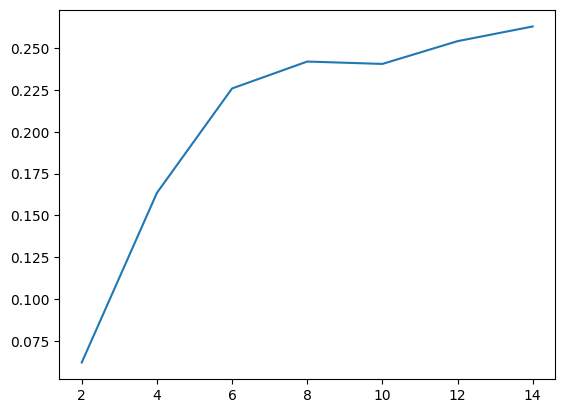

In [43]:
#END SALARY
krange=range(2,15,2)
plt.plot(krange,sclist)
sclist

In [44]:
for k in tqdm(range(15,30,4)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|█████████████████████████████████████████████| 4/4 [02:26<00:00, 36.68s/it]


[0.06201419155605651,
 0.16347620028913656,
 0.2259556511306123,
 0.24205504144075532,
 0.24062762322737508,
 0.25424508729679884,
 0.2630322448327744,
 0.26846239805099364,
 0.2815241463975813,
 0.2881207807942673,
 0.2921732981538288]

In [47]:
#END SALARY
# krange=range(15,30,4)
# plt.plot(krange,sclist)
# sclist

## Model with Start Salary + Encoding

In [48]:
X=df_testing[['Total_Year','Level', 'Career']]
y=df_testing['Start_Salary']

In [49]:
offset = int(X.shape[0] * 0.8)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_57758/1895287373.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, y_train = X[:offset], y[:offset]
/var/folders/74/zq1vl5mj4518hvqv44mrtkd80000gn/T/ipykernel_57758/1895287373.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_test, y_test = X[offset:], y[offset:]


In [50]:
X_train_transform=X_train.copy()
from sklearn.preprocessing import OneHotEncoder
enc_level = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_level.fit(X_train[['Level']])
level_cat=enc_level.categories_[0]
for x in range(len(level_cat)):
    X_train_transform[level_cat[x]]=enc_level.transform(X_train[['Level']]).T[x]
enc_career = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_career.fit(X_train[['Career']])
career_cat=enc_career.categories_[0]
for x in range(len(career_cat)):
    X_train_transform[career_cat[x]]=enc_career.transform(X_train[['Career']]).T[x]
X_train_transform=X_train_transform.drop(columns=['Level','Career'])
X_train_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Admin,Administ,Airport,...,Library,Mayor,Mechanic,Medical,Parking,Police,Public Works,Real Estate,Sicience,Transit
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206077,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
206083,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
206095,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206096,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
X_test_transform=X_test.copy()
for x in range(len(level_cat)):
    X_test_transform[level_cat[x]]=enc_level.transform(X_test[['Level']]).T[x]
for x in range(len(career_cat)):
    X_test_transform[career_cat[x]]=enc_career.transform(X_test[['Career']]).T[x]
X_test_transform=X_test_transform.drop(columns=['Level','Career'])
X_test_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Admin,Administ,Airport,...,Library,Mayor,Mechanic,Medical,Parking,Police,Public Works,Real Estate,Sicience,Transit
206113,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
206114,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
206120,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206124,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
206125,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259505,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259506,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259509,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259510,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
sclist=[]
for k in tqdm(range(30,50)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|███████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it]


[0.25498308978898027,
 0.2589714287126164,
 0.2600787722267001,
 0.25498465505318063,
 0.2536042037772197,
 0.25427289161988825,
 0.2518002843910713,
 0.25740837940259176,
 0.2599779466837561,
 0.25908599330950843,
 0.2578061022329841,
 0.25703938104811247,
 0.25627301804396724,
 0.25495822435480825,
 0.25645950683534496,
 0.25680984441237176,
 0.2561461433227612,
 0.2588507374131239,
 0.25928384003240673,
 0.2588575917829559]

[0.25498308978898027,
 0.2589714287126164,
 0.2600787722267001,
 0.25498465505318063,
 0.2536042037772197,
 0.25427289161988825,
 0.2518002843910713,
 0.25740837940259176,
 0.2599779466837561,
 0.25908599330950843,
 0.2578061022329841,
 0.25703938104811247,
 0.25627301804396724,
 0.25495822435480825,
 0.25645950683534496,
 0.25680984441237176,
 0.2561461433227612,
 0.2588507374131239,
 0.25928384003240673,
 0.2588575917829559]

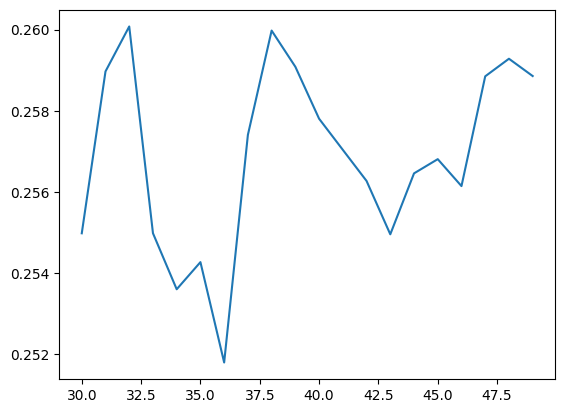

In [53]:
#END SALARY
krange=range(30,50)
plt.plot(krange,sclist)
sclist

## Make model Medical

In [56]:
X=main_df[['Total_Year','Level', 'Career']]
y=main_df['End_Salary']

In [57]:
offset = int(X.shape[0] * 0.8)

X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [58]:
X_train_transform=X_train.copy()
from sklearn.preprocessing import OneHotEncoder
enc_level = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_level.fit(X_train[['Level']])
level_cat=enc_level.categories_[0]
for x in range(len(level_cat)):
    X_train_transform[level_cat[x]]=enc_level.transform(X_train[['Level']]).T[x]
enc_career = OneHotEncoder(handle_unknown='ignore',sparse=False)
enc_career.fit(X_train[['Career']])
career_cat=enc_career.categories_[0]
for x in range(len(career_cat)):
    X_train_transform[career_cat[x]]=enc_career.transform(X_train[['Career']]).T[x]
X_train_transform=X_train_transform.drop(columns=['Level','Career'])
X_train_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Admin,Administ,Airport,...,Library,Mayor,Mechanic,Medical,Parking,Police,Public Works,Real Estate,Sicience,Transit
0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207610,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207611,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207612,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207613,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
X_test_transform=X_test.copy()
for x in range(len(level_cat)):
    X_test_transform[level_cat[x]]=enc_level.transform(X_test[['Level']]).T[x]
for x in range(len(career_cat)):
    X_test_transform[career_cat[x]]=enc_career.transform(X_test[['Career']]).T[x]
X_test_transform=X_test_transform.drop(columns=['Level','Career'])
X_test_transform

,Total_Year,Manager,Other,Senior,Staff,Trainee,Accountant,Admin,Administ,Airport,...,Library,Mayor,Mechanic,Medical,Parking,Police,Public Works,Real Estate,Sicience,Transit
207615,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207616,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207617,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
207618,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
207619,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259514,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259515,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259516,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
259517,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [63]:
X=X_test_transform[['Total_Year','Medical']]
y=main_df['End_Salary']

In [65]:
X

,Total_Year,Medical
207615,5,1.0
207616,6,1.0
207617,6,1.0
207618,1,0.0
207619,2,0.0
...,...,...
259514,5,0.0
259515,6,0.0
259516,7,0.0
259517,8,0.0


In [66]:
y

0          23514.85
1          29379.24
2          30153.03
3          33363.71
4          37594.90
            ...    
259514    142176.10
259515    148041.92
259516    136547.78
259517     86066.55
259518      3331.77
Name: End_Salary, Length: 259519, dtype: float64

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
sclist=[]
for k in tqdm(range(30,50)):
    neigh = KNeighborsRegressor(n_neighbors=k)
    #neigh.fit(X_train, y_train)
    sc=cross_val_score(neigh , X_train_transform, y_train, cv=3).mean()
    sclist.append(sc)
sclist
# neigh.score(X_test, y_test )

100%|███████████████████████████████████████████| 20/20 [12:30<00:00, 37.52s/it]


[0.29568529109000136,
 0.2977422007217428,
 0.3004036551896942,
 0.3008678580235347,
 0.3023297849629564,
 0.30244578563337293,
 0.3038409077703277,
 0.30562196829444027,
 0.3069871198827188,
 0.3076594311383353,
 0.30785291259878966,
 0.308527170047135,
 0.3090006493759943,
 0.3091300991545576,
 0.3098633959210818,
 0.3107363584830673,
 0.3114485797314269,
 0.3117156932074654,
 0.31207772244194326,
 0.31288495532955]

[0.29568529109000136,
 0.2977422007217428,
 0.3004036551896942,
 0.3008678580235347,
 0.3023297849629564,
 0.30244578563337293,
 0.3038409077703277,
 0.30562196829444027,
 0.3069871198827188,
 0.3076594311383353,
 0.30785291259878966,
 0.308527170047135,
 0.3090006493759943,
 0.3091300991545576,
 0.3098633959210818,
 0.3107363584830673,
 0.3114485797314269,
 0.3117156932074654,
 0.31207772244194326,
 0.31288495532955]

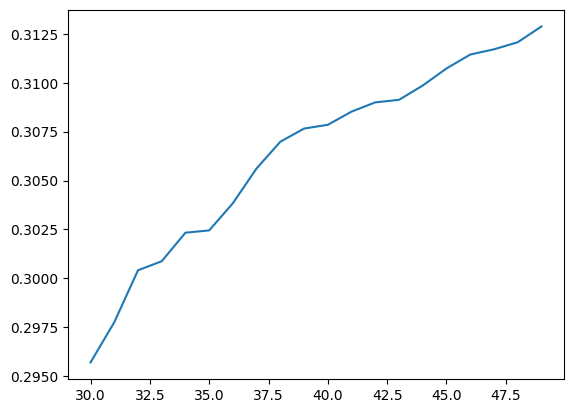

In [68]:
#END SALARY
krange=range(30,50)
plt.plot(krange,sclist)
sclist